In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load preprocessed dataset
df = pd.read_parquet("../data/processed_emoji_dataset.parquet")

# Convert embeddings to float32 numpy arrays
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

In [4]:
class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text_embedding = torch.tensor(self.dataframe.iloc[idx]["combined_embedding"]).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]["image_path"]).float()
        return text_embedding, image_tensor


In [5]:
# Create DataLoader
dataset = EmojiDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [6]:
for embeddings, images in dataloader:
    print(embeddings.shape, images.shape)
    break

torch.Size([64, 384]) torch.Size([64, 3, 32, 32])


In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )

        self.encoder1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128 + 128, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        x = self.bottleneck(x)

        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)

        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)

        return self.final_conv(x)


In [8]:
class DiffusionModel:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def add_noise(self, images, t):
        noise = torch.randn_like(images)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        noisy_images = torch.sqrt(alpha_bar_t) * images + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_images, noise

    def sample(self, model, shape):
        x = torch.randn(shape).to(device)
        for t in reversed(range(self.timesteps)):
            with torch.no_grad():
                noise_pred = model(x)
                beta_t = self.beta[t].view(1, 1, 1, 1)
                alpha_t = self.alpha[t].view(1, 1, 1, 1)
                alpha_bar_t = self.alpha_bar[t].view(1, 1, 1, 1)

                if t > 0:
                    z = torch.randn_like(x)  
                else:
                    z = 0  # No noise at final step

                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred) + torch.sqrt(beta_t) * z
        return x


In [9]:
# Initialize Model, Diffusion, and Training Setup
model = UNet().to(device)
diffusion = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()

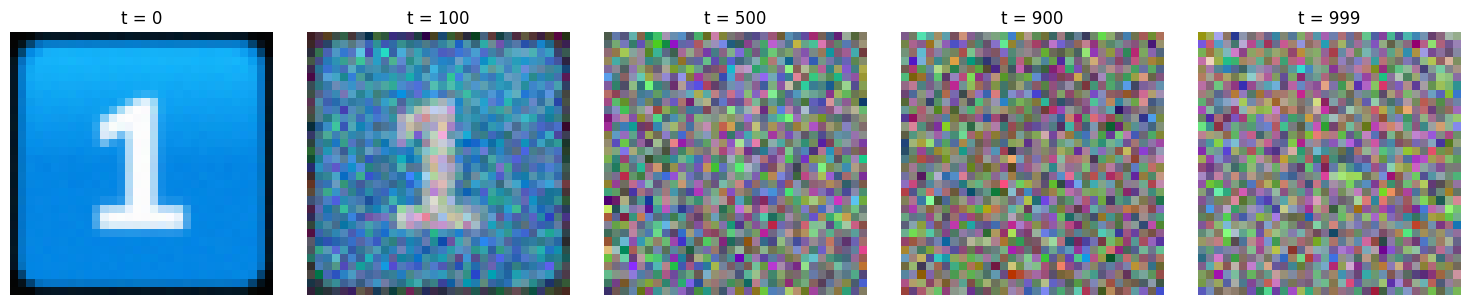

In [10]:
# Select a real image from the dataset
_, real_image = dataset[11]  # Get an image (ignore text embedding)
real_image = real_image.unsqueeze(0).to(device)  # Add batch dim & move to GPU

# Define timesteps to visualize
timesteps = [0, 100, 500, 900, 999]  # 0 (original), 999 (maximum noise)
noisy_images = []

# Apply noise using the DiffusionModel class
diffusion = DiffusionModel(timesteps=1000)  # Ensure it matches your training setup

for t in timesteps:
    t_tensor = torch.tensor([t], dtype=torch.long, device=device)  # Convert t to tensor
    xt, _ = diffusion.add_noise(real_image, t_tensor)

    # Convert to CPU & normalize for visualization
    img_np = xt.cpu().squeeze(0).permute(1, 2, 0).numpy()

    # Normalize image to [0,1] to prevent display issues
    img_min, img_max = img_np.min(), img_np.max()
    if img_max > img_min:  # Avoid division by zero
        img_np = (img_np - img_min) / (img_max - img_min)
    
    noisy_images.append(img_np)

# Plot the images
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(noisy_images[i])
    ax.set_title(f"t = {timesteps[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Initialize model, loss function, and optimizer
model = UNet().to(device)
loss_fn = nn.MSELoss()  # Use appropriate loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 100
epoch_loss_values = []  # Store average loss per epoch

for epoch in range(epochs):
    total_loss = 0  # Accumulate loss for the epoch
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")
    
    for embeddings, images in loop:
        images = images.to(device)
        t = torch.randint(0, 1000, (images.shape[0],), dtype=torch.long).to(device)
        noisy_images, noise = diffusion.add_noise(images, t)

        predicted_noise = model(noisy_images)
        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        total_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    epoch_loss_values.append(avg_loss)

print("Training Completed!")


Epoch [1/100]:  63%|██████▎   | 123/196 [00:06<00:03, 19.77it/s, loss=0.222]

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "diffusion_emoji.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# 🔹 Plot the Loss per Epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_loss_values, marker="o", linestyle="-", color="red", label="Epoch Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load the trained model
model = UNet().to(device)  # Initialize model architecture
model.load_state_dict(torch.load("diffusion_emoji.pth", map_location=device))
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import matplotlib.pyplot as plt

def sample_emoji(model, diffusion, num_samples=50):
    model.eval()
    with torch.no_grad():
        sampled_images = diffusion.sample(model, (num_samples, 3, 32, 32))
    return sampled_images.cpu()

# Load trained model
model = UNet().to(device)
model.load_state_dict(torch.load("diffusion_emoji.pth", map_location=device))
model.eval()

# Generate 50 images
num_samples = 50
sampled_emojis = sample_emoji(model, diffusion, num_samples)

# Define grid size (e.g., 10 rows, 5 columns)
rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

# Plot images in grid
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        img = sampled_emojis[i].permute(1, 2, 0).clamp(0, 1)  # Convert to (H, W, C)
        ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'UNet' is not defined